# LSTM Autoencoder for Anomaly Detection

## Using LSTM Autoencoder to Detect Anomalies and Classify Rare Events

So many times, actually most of real-life data, we have unbalanced data. Data were the events in which we are interested the most are rare and not as frequent as the normal cases. As in fraud detection, for instance. Most of the data is normal cases, whether the data is already labeled or not, and we want to detect the anomalies or when the fraud happens.
When dealing with unlabeled data, we usually go to **"outliers detection"** methods such as [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest), **Cluster-Based Local Outlier Factor (CBLOF)**, **Histogram-Based Outlier Detection (HBOS)** etc. While labeled data is considered as a **"classification"** problem and classifiers like [Support Vector Machine (SVM)](https://en.wikipedia.org/wiki/Support-vector_machine) and [Random Forest](https://en.wikipedia.org/wiki/Random_forest) are used. However, given the positive data points are rare in the data, the algorithm finds it difficult to learn so much from the data. A classifier for example, usually ends up predicting "negative" for all cases to achieve the best accuracy.
Here we will look at a different approach that can be used in both supervised and unsupervised [anomaly detection](https://en.wikipedia.org/wiki/Anomaly_detection) and rare event classification problems. **Long Short-Term Memory Autoencoders**. 

[Long Short-Term Memory](https://en.wikipedia.org/wiki/Long_short-term_memory) neural network is a special type of Recurrent neural networks. LSTMs are great in capturing and learning the intrinsic order in sequential data as they have internal memory. That’s why they are famous in speech recognition and machine translation.

On the other hand, an [autoencoder](https://en.wikipedia.org/wiki/Autoencoder) can learn the lower dimensional representation of the data capturing the most important features within it. Autoencoder mainly consist of three main parts:

    1) Encoder, which tries to reduce data dimensionality. 
    2) Code, which is the compressed representation of the data. 
    3) Decoder, which tries to revert the data into the original form without losing much information.

Here we will see how we can combine the two techniques to approach rare event classification.
In a [previous blog](https://minimatech.org/autoencoder-with-manifold-learning-for-clustering-in-python/), we have looked at another use case of autoencoders in clustering.

### Problem Description

We will use **Credit Card Fraud** dataset to predict frauds. The data we will use is available at this [GitHub repository](https://github.com/GuansongPang/anomaly-detection-datasets). Thanks to this repository, the data is prepared for modelling. Features and normalized and everything is ready for the modeling part.

### Approach Description

Autoencoders try to capture the most important features and structures in data. With the help of LSTMs, it can capture the order in data, and then re-represent it in a denoised lower dimensional form. We will use this power to make the autoencoder learn the features of a normal data point only, i.e. we will train the autoencoder only with the negative/non-fraud observations. The autoencoder will try to compress the data then reconstruct it again. Upon training, the autoencoder will be able to reconstruct the normal observations with small error or difference between the original data. However, when it tries to predict/reconstruct a positive/fraud observation, it will somehow be surprised as it never saw such sequences while trained. So the reconstruction error between original and reconstructed data will be high for fraudulent ones than for normal ones. We will then set the threshold that separates the normal and the fraud observations.
Things will be clearer with code. So let's get into the real work.

N.B. This technique is useful for unsupervised anomaly detection as well.

### Data Preparation

As usual we will start importing all the classes and functions we will need.

In [1]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Input, Model
from keras.layers import Dense, LSTM
from keras.layers import RepeatVector, TimeDistributed
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, auc, roc_curve
np.random.seed(13)

Now we will read the downloaded data and look at the percentage of the positive class in it.

In [2]:
with tarfile.open("creditcardfraud_normalised.tar.gz", "r:*") as tar:
    csv_path = tar.getnames()[0]
    df = pd.read_csv(tar.extractfile(csv_path))
    
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,class
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,...,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,...,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,...,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,...,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,...,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0


In [3]:
print("class counts:\n", df["class"].value_counts())
print("\n%% of positive values in data: %.2f%%" % 
      ((df[df["class"] == 1].shape[0] / df.shape[0]) * 100))

class counts:
 0    284315
1       492
Name: class, dtype: int64

% of positive values in data: 0.17%


To make the problem a little bit harder, we will make the positive observations a little bit more scarse by removing some of it randomly.

In [4]:
df = df.drop(df.query("`class` > 0").sample(frac = 0.25).index)
print(df["class"].value_counts())
print("\n%% of positive values in data after deleting some: %.2f%%" % 
      ((df[df["class"] == 1].shape[0] / df.shape[0]) * 100))

predictors = df.drop(["class"], axis = 1)
target = df["class"]

0    284315
1       369
Name: class, dtype: int64

% of positive values in data after deleting some: 0.13%


As we have mentioned, the data is already transform, normalized and prepared for modeling, so we will now split the data into train and test.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    predictors, target, 
    stratify = target, 
    random_state = 13, 
    test_size = 0.25)

We want to train the autoencoder with negative observations only, so we willprepare the train dataset with removing all positive cases. Also from the test dataset we prepare a validation dataset that we will use while modeling and afterwards to se the threshold.

In [6]:
X_val = X_test[:3000]
y_val = y_test[:3000]
X_test = X_test[3000:]
y_test = y_test[3000:]
X_train_0 = X_train[y_train != 1]
y_train_0 = y_train[y_train != 1]
X_test_0 = X_test[y_test != 1]
X_val_0 = X_val[y_val != 1]
y_train_0 = y_train[y_train != 1]

LSTMs expect a 3D arrays, so we will define a function that converts 2D to 3D arrays. In addition, we will define a function that flattens a 3D array back to a 2D one. The mse_3d function will calculate the reconstruction error between the original and the reconstructed data.

In [7]:
def arr_reshape(x, arr_type = "float32"):
    return np.asarray(x).astype(arr_type).reshape((-1, 1, x.shape[1]))

def flatten(arr):
    return arr.reshape(-1, arr.shape[-1])

def mse_3d(x, y):
    return np.mean(np.power(flatten(x) - flatten(y), 2), axis = 1)

We now reshape all data that the autoencoder will use.

In [8]:
reshaped_train_0 = arr_reshape(X_train_0)
reshaped_val_0 = arr_reshape(X_val_0)
reshaped_test_0 = arr_reshape(X_test_0)
reshaped_val = arr_reshape(X_val)
reshaped_test = arr_reshape(X_test)
reshaped_train = arr_reshape(X_train)

In [9]:
inputs_dim = reshaped_train_0.shape[2]

Now to the fun part. The model.

We will wrap the model and all its function a Python class so that we have everything in one place.

The class methods will have default arguments with the values that we decided to use in our model. Feel free to change them if needed.

In [10]:
class LSTMAutoencoder(Model):
    ## the class is initiated with the number of dimensions and 
    ## timesteps (the 2nd dimension in the 3 dimensions) and the number of dimensions
    ## to which we want the encoder to represent the data (bottleneck)
    def __init__(self, n_dims, n_timesteps = 1, 
                 n_bottleneck = 8, bottleneck_name = "bottleneck"):
        super().__init__()
        self.bottleneck_name = bottleneck_name
        self.build_model(n_dims, n_timesteps, n_bottleneck)
        
    
    ## each of the encoder and decoder will have two layers with hard coded parameters
    ## for simplicity
    def build_model(self, n_dims, n_timesteps, n_bottleneck):
        self.inputs = Input(shape = (n_timesteps, n_dims))
        e = LSTM(16, activation = "relu", return_sequences = True)(self.inputs)
        ## this is the code layer or the compressed form of the data produced by the autoencoder
        self.bottleneck = LSTM(n_bottleneck, activation = "relu", 
                               return_sequences = False, 
                               name = self.bottleneck_name)(e)
        e = RepeatVector(n_timesteps)(self.bottleneck)
        decoder = LSTM(n_bottleneck, activation = "relu", return_sequences = True)(e)
        decoder = LSTM(16, activation = "relu", return_sequences = True)(decoder)
        self.outputs = TimeDistributed(Dense(n_dims))(decoder)
        self.model = Model(inputs = self.inputs, outputs = self.outputs)
        
    
    ## model summary
    def summary(self):
        return self.model.summary()
    
    
    ## compiling the model with adam optimizer and mean squared error loss
    def compile_(self, lr = 0.0003, loss = "mse", opt = "adam"):
        if opt == "adam":
            opt = optimizers.Adam(learning_rate = lr)
        else:
            opt = optimizers.SGD(learning_rate = lr)
        self.model.compile(loss = loss, optimizer = opt)
    
    
    ## adding some model checkpoints to ensure the best values will be saved
    ## and early stopping to prevent the model from running in vain
    def callbacks(self, **kwargs):
        self.mc = ModelCheckpoint(filepath = kwargs.get("filename"), 
                                  save_best_only = True, verbose = 0)
        
        self.es = EarlyStopping(monitor = kwargs.get("monitor"),
                                patience = kwargs.get("patience"))
        
    
    ## model fit
    def train(self, x, y, x_val = None, y_val = None, 
              n_epochs = 15, batch_size = 32, 
              verbose = 1, callbacks = None):
        if x_val is not None:
            self.model.fit(x, y, validation_split = 0.2,
                          epochs = n_epochs, verbose = verbose,
                          batch_size = batch_size)
        else:
            self.model.fit(x, y, validation_data = (x_val, y_val),
                          epochs = n_epochs, verbose = verbose,
                          batch_size = batch_size, 
                          callbacks = [self.mc, self.es])
    
    
    ## reconstruct the new data 
    ## should be with lower error for negative values than
    ## the error with the positive ones
    def predict(self, xtest):
        return self.model.predict(xtest)
    
    
    ## after investigating the error differences, we set the threshold
    def set_threshold(self, t):
        self.threshold = t
        
    ## after setting the threshold, we can now predict the classes from the
    ## reconstructed data
    def predict_class(self, x_test, predicted):
        mse = mse_3d(x_test, predicted)
        return 1 * (mse > self.threshold)
    
    
    ## just in case we are interested in extracting the (bottleneck) the low-dimension 
    ## representation of the data
    def encoder(self, x):
        self.encoder_layer = Model(inputs = self.inputs, outputs = self.bottleneck)
        return self.encoder_layer.predict(x)

Initiate now the model.

In [11]:
lstm = LSTMAutoencoder(inputs_dim)
lstm.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 29)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             2944      
_________________________________________________________________
bottleneck (LSTM)            (None, 8)                 800       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 8)              544       
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 16)             1600      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 29)             493   

Setting the callbacks and compiling the model.

In [12]:
lstm.callbacks(filename = "./lstm_autoenc.h5", patience = 3, monitor = "val_loss")
lstm.compile_()

The main step! Model fitting on the negative/non-fraud observations.

In [13]:
lstm.train(reshaped_train_0, reshaped_train_0, 
           reshaped_val_0, reshaped_val_0, 
           n_epochs = 10)

Epoch 1/10
5331/5331 [==============================] - 15s 2ms/step - loss: 0.0515 - val_loss: 0.0016
Epoch 2/10
5331/5331 [==============================] - 13s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 3/10
5331/5331 [==============================] - 13s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 4/10
5331/5331 [==============================] - 13s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/10
5331/5331 [==============================] - 13s 2ms/step - loss: 9.7148e-04 - val_loss: 8.8441e-04
Epoch 6/10
5331/5331 [==============================] - 13s 2ms/step - loss: 8.7564e-04 - val_loss: 8.5562e-04
Epoch 7/10
5331/5331 [==============================] - 13s 2ms/step - loss: 8.6155e-04 - val_loss: 8.4108e-04
Epoch 8/10
5331/5331 [==============================] - 13s 2ms/step - loss: 8.4307e-04 - val_loss: 8.2673e-04
Epoch 9/10
5331/5331 [==============================] - 13s 2ms/step - loss: 8.2738e-04 - val_loss: 8.0289e-04
Epoch 10/10
5331/5331 [==========

Now the model seems to have kind of converged. Great! Now let's try to set the threshold that separates the normal from the fraud cases.

We will make the model predict/reconstruct the validation data (including the positive cases) and compute the Mean Squared Error between the reconstructed and original data. Then using the actual classes and the error values, we will calculate and plot the recall and precision and try to spot a suitable error value that gives good recall and precision.

In [14]:
val_preds = lstm.predict(reshaped_val)
val_mse = mse_3d(reshaped_val, val_preds)
val_error = pd.DataFrame({
    "mse": val_mse,
    "actual": y_val
})

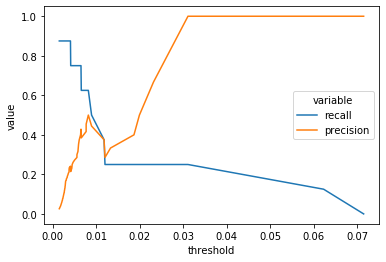

In [15]:
precision, recall, threshold = precision_recall_curve(
    val_error["actual"], val_error["mse"])
val_prt = pd.DataFrame({
    "threshold": threshold,
    "recall": recall[1:],
    "precision": precision[1:]
})
val_prt_melted = pd.melt(val_prt, id_vars = ["threshold"],
                         value_vars = ["recall", "precision"])
sns.lineplot(x = "threshold", y = "value",
             hue = "variable", data = val_prt_melted)

Value 0.01 seems to be a good threshold. Having a very low value, can mean that negative and positive cases are somehow so similar in essence.

In [16]:
lstm.set_threshold(0.01)

Now we look at how this threshold value can separate the cases in the test data. We will first reconstruct the test dataset and again compute the MSE between the reconstructed and original data.

In [17]:
test_preds = lstm.predict(reshaped_test)
test_mse = mse_3d(reshaped_test, test_preds)
test_error = pd.DataFrame({"mse": test_mse,
                        "actual": y_test})

Let's now see the distribution of the error values and how well the threshold separates the error (high) for the positive cases.

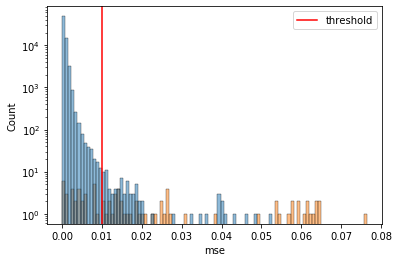

In [18]:
g = sns.histplot(x = "mse", hue = "actual", 
                 data = test_error, bins = 100)
plt.axvline(lstm.threshold, color = "r", label = "threshold")
plt.legend(loc = "upper right")
g.set_yscale("log")
plt.show()

It seems that after the threshold, yes the positive cases increase while the negative ones decrease.

Another visualization for the threshold

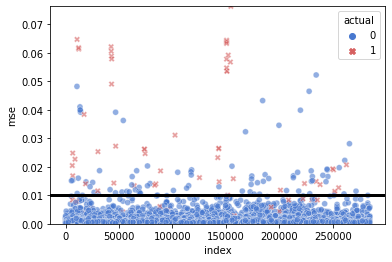

In [19]:
g = sns.scatterplot(
        x = "index", y = "mse", 
        hue = "actual", style = "actual", 
        data = test_error.reset_index(),
        palette = {0: "#4878CF", 1: "#D65F5F"},
        alpha = 0.6)
g.set(ylim = (0, max(test_error.mse)))
g.axhline(lstm.threshold, color = "black", linewidth = 3)

As we see, the normal cases seem to lie down the threshold and most of the fraud cases are above it. 

Let's now evaluate the model performance and look at the accuracy, recall and precision as well as the confusion matrix.

In [20]:
pred_y = lstm.predict_class(reshaped_test, test_preds)
conf_matrix = confusion_matrix(y_test, pred_y)
print("Accuracy: %.2f%%" % (100 * accuracy_score(y_test, pred_y)))
print("Precision: %.2f%%" % (100 * precision_score(y_test, pred_y)))
print("Recall: %.2f%%" % (100 * recall_score(y_test, pred_y)))

Accuracy: 99.84%
Precision: 40.00%
Recall: 64.29%


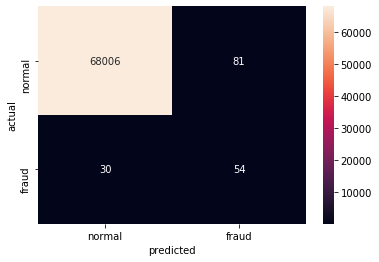

In [21]:
sns.heatmap(conf_matrix, 
            xticklabels = ["normal", "fraud"], 
            yticklabels=["normal", "fraud"], 
            annot = True, fmt = "d");
plt.ylabel("actual")
plt.xlabel("predicted")
plt.show()

Looking at the Area Under the Curve (AUC) is also important in evaluating a classifier.

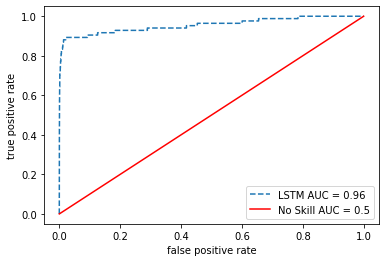

In [22]:
fpr, tpr, _ = roc_curve(test_error["actual"], test_error["mse"])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, ls = "--", label = "LSTM AUC = %0.2f" % roc_auc)
plt.plot([0,1], [0,1], c = "r", label = "No Skill AUC = 0.5")
plt.legend(loc = "lower right")
plt.ylabel("true positive rate")
plt.xlabel("false positive rate")
plt.show()

The autoencoder with the set threshold seems to perform so well in detecting the anomalies (fraud cases).

Another classifier, like SVM or [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression), would perform better on this data. But LSTM Autoencoder outperforms them when the positive observations are so scarse in data. It is really a great tool to add to your skilset.